<a href="https://colab.research.google.com/github/stevejj4/SHOFCO-SUN/blob/feature-branch/Transformations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [167]:
import pandas as pd
from google.colab import auth
import gspread
from google.auth import default

# Authorize Google Colab
auth.authenticate_user()

# Credentials for Google Sheets
creds, _ = default()
gc = gspread.authorize(creds)

# Loading the Google Sheet
spreadsheet = gc.open('SUN_Finance_Dashboard')
# Checking if the sheet 'transformed' exists and create it if not

try:
    transformed_sheet = spreadsheet.worksheet('transformed')
except gspread.exceptions.WorksheetNotFound:
    transformed_sheet = spreadsheet.add_worksheet(title='transformed', rows="1000", cols="20")

# Load the original data
worksheet = spreadsheet.sheet1
rows = worksheet.get_all_values()

# Create DataFrame from the sheet data
df = pd.DataFrame(rows)
df.columns = df.iloc[0]  # Setting the first row as column names
df = df.iloc[1:]  # Remove the first row


In [168]:
df.shape

(68, 27)

In [169]:
# To list practice
#The tolist() function is used to convert a given array to an ordinary list with the same itmes, elements or values.
# aaray.tolist()
# to list does not take any parameters
# to list function returns a list that contains the same items of the original array
#Example
import array as arr
 # creating an integer data type array
x = arr.array('i', [1,2,3,4,5,6,7,])
 # using the tolist() function to change the array to a list
y = x.tolist()

print(y)

[1, 2, 3, 4, 5, 6, 7]


In [170]:
# Reshape the data from wide to long format
# Dynamic
# A simple ETL process that after extraction the data is transformed and loaded
# the goal is make analysis of trend easy
# preparing data for further analytics and machine learning
value_vars = ['Contribution', 'Compensation', 'Deaths']
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July']

# Initialize an empty list to store the reshaped data
reshaped_data = []

# Iterate through each row in the DataFrame
for _, row in df.iterrows():
    for month in months:
        # Useing the actual column names from the DataFrame
        contribution_col = next((col for col in df.columns if month in col and 'Contribution' in col), None)
        compensation_col = next((col for col in df.columns if month in col and 'Compensation' in col), None)
        deaths_col = next((col for col in df.columns if month in col and 'deaths' in col), None)

        reshaped_data.append({
            'PAYBILL NO': row['PAYBILL NO'],
            'SUB COUNTY': row['SUB COUNTY'],
            'REGION': row['REGION'],
            'Cluster': row['Cluster'],
            'County': row['County'],
            'Site': row['Site'],
            'Month': month,
            'Contribution': row[contribution_col] if contribution_col else None,  # Handle cases where the column might not exist
            'Compensation': row[compensation_col] if compensation_col else None,
            'Deaths_per_Month': row[deaths_col] if deaths_col else None
        })

# Create a new DataFrame from the reshaped data
reshaped_df = pd.DataFrame(reshaped_data)

# Convert the DataFrame to a list of lists
reshaped_data_list = [reshaped_df.columns.values.tolist()] + reshaped_df.values.tolist()

# Clear the 'transformed' sheet
transformed_sheet.clear()

# Write the reshaped DataFrame to the 'transformed' sheet
transformed_sheet.update('A1', reshaped_data_list)

# Print confirmation
print('Data successfully loaded into the transformed sheet.')

<ipython-input-170-622d9dfae5e5>:43: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  transformed_sheet.update('A1', reshaped_data_list)


Data successfully loaded into the transformed sheet.


In [171]:
# Select the sheet named 'transformed'
worksheet = spreadsheet.worksheet('transformed')

# Get all the values from the sheet
rows = worksheet.get_all_values()

# Convert the data to a pandas DataFrame
df = pd.DataFrame(rows)

# Set the first row as the header
df.columns = df.iloc[0]
df = df.drop(0)

In [172]:
#Select sheet named Transactions_Details and MemberDatails
worksheet_TD = spreadsheet.worksheet('Transactions_Details')
worksheet_MD = spreadsheet.worksheet('MemberDatails')

#Getting values from Transction_Details and MemberDetails
rows_TD = worksheet_TD.get_all_values()
rows_MD = worksheet_MD.get_all_values()

# Convertting the data to a pandas DataFrame
df_TD = pd.DataFrame(rows_TD)
df_MD = pd.DataFrame(rows_MD)

# Setting the first row as the header
df_TD.columns = df_TD.iloc[0]
df_TD = df_TD.drop(0)

df_MD.columns = df_MD.iloc[0]
df_MD = df_MD.drop(0)

In [173]:
# creating another sheet called AgeDist that is a manifestation of left join
# Checking if a sheet named 'AgeDist' already exists. If it does, just proceed.
try:
    age_dist_sheet = spreadsheet.worksheet('AgeDist')  # Trying to get the existing sheet
    print("Sheet 'AgeDist' already exists. Proceeding with data load.")
except gspread.exceptions.WorksheetNotFound:
    # Creating the sheet if it doesn't exist
    age_dist_sheet = spreadsheet.add_worksheet(title='AgeDist', rows="1000", cols="20")
    print("Sheet 'AgeDist' created.")

# Performing the left join to include all CHQ_NO from df_TD and corresponding age and gender from df_MD
age_dist_df = pd.merge(df_TD, df_MD, on='CHQ_NO', how='left')

# Loading the data, filling NaN for missing values
age_dist_data_list = [age_dist_df.columns.values.tolist()]
age_dist_values = age_dist_df.fillna('').values.tolist()
age_dist_data_list.extend(age_dist_values)

# Updating the 'AgeDist' sheet with the data
age_dist_sheet.update('A1', age_dist_data_list)

Sheet 'AgeDist' already exists. Proceeding with data load.


<ipython-input-173-35f88b5f6a7b>:20: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  age_dist_sheet.update('A1', age_dist_data_list)


{'spreadsheetId': '1orN8n1tSFlMS-XpseNl7sBpb7zjOhCdUY0O6zPSWstg',
 'updatedRange': 'AgeDist!A1:G270',
 'updatedRows': 270,
 'updatedColumns': 7,
 'updatedCells': 1890}

In [191]:
# Dropping the last column to keep only 6 columns
age_dist_df = age_dist_df.iloc[:, :-1]
age_dist_df.columns

Index(['Transaction', 'CHQ_NO', 'Site', 'Money Out', 'AGE', 'Gender'], dtype='object', name=0)

In [192]:
age_dist_df.shape

(269, 6)

In [193]:
age_dist_df.isnull().sum()

0
Transaction     0
CHQ_NO          0
Site            0
Money Out       0
AGE            65
Gender         65
dtype: int64

In [200]:

# Convert 'AGE' column to numeric, handling non-numeric values

def categorize_age(age_str):
    try:
        age_years = float(age_str)
        if age_years >= 1 and age_years < 2:
            return 2
        else:
            return age_years  # Keep ages outside the 1-2 range as they are
    except ValueError:
        if '/' in age_str:
            return 1  # Assign 1 for ages in 'a/b' format
        else:
            return np.nan  # Return NaN for other non-numeric formats

age_dist_df['AGE'] = age_dist_df['AGE'].apply(categorize_age)

0
Transaction     0
CHQ_NO          0
Site            0
Money Out       0
AGE            15
Gender         65
dtype: int64

In [211]:
def fill_missing_age(group):
    # Fill missing AGE with mode within the group or global mode if all missing
    mode_age = group['AGE'].mode()
    if not mode_age.empty:
        group['AGE'] = group['AGE'].fillna(mode_age[0])
    else:
        group['AGE'] = group['AGE'].fillna(age_dist_df['AGE'].mode()[0])

    # Fill missing Gender with mode within the group or global mode if all missing
    mode_gender = group['Gender'].mode()
    if not mode_gender.empty:
        group['Gender'] = group['Gender'].fillna(mode_gender[0])
    else:
        group['Gender'] = group['Gender'].fillna(age_dist_df['Gender'].mode()[0])

    return group

age_dist_df = age_dist_df.groupby('Site').apply(fill_missing_age).reset_index(level=0, drop=True)

# Check for remaining missing values
print(age_dist_df.isnull().sum())

0
Transaction    0
CHQ_NO         0
Site           0
Money Out      0
AGE            0
Gender         0
dtype: int64


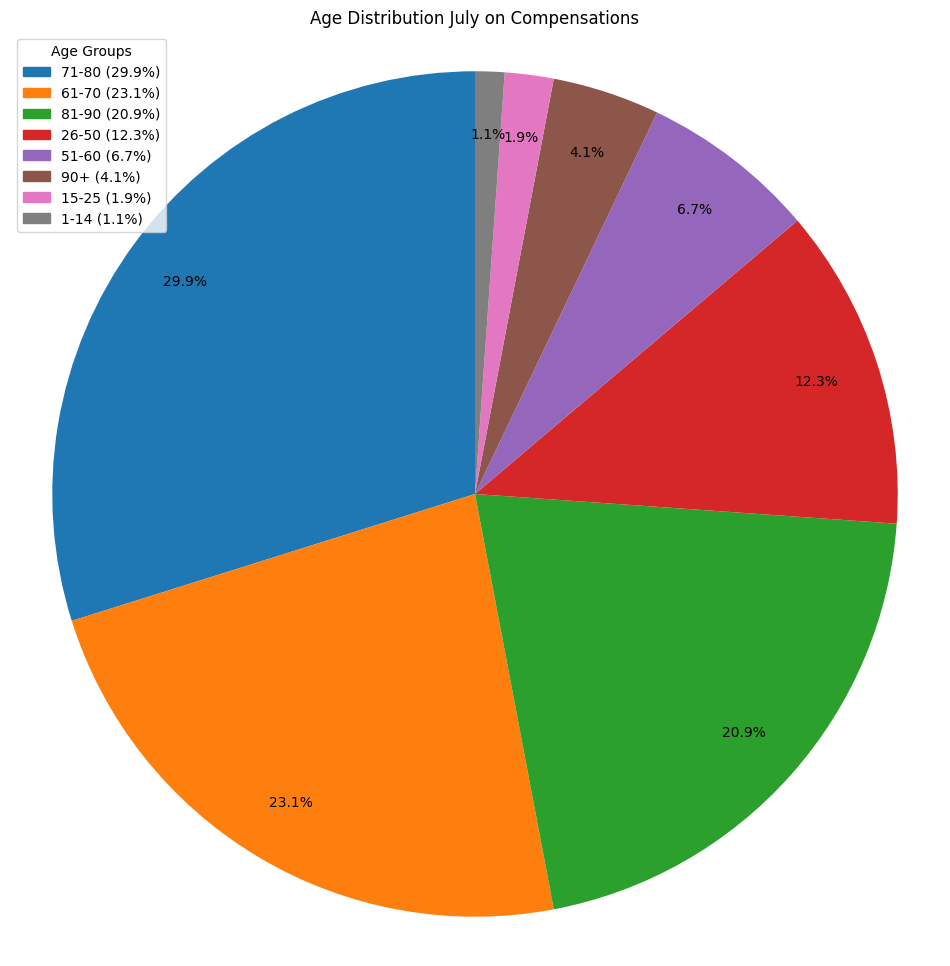

In [221]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Assuming you have your age_dist_df DataFrame ready with the 'AGE' column

# Define age bins
age_bins = [1, 14, 25, 50, 60, 70, 80, 90, float('inf')]
age_labels = ['1-14', '15-25', '26-50', '51-60', '61-70', '71-80', '81-90', '90+']

# Categorize ages into bins
age_dist_df['Age Group'] = pd.cut(age_dist_df['AGE'], bins=age_bins, labels=age_labels, right=False)

# Calculate percentage distribution
age_group_counts = age_dist_df['Age Group'].value_counts()
age_group_percentages = age_group_counts / age_group_counts.sum() * 100

# Create the pie chart
fig, ax = plt.subplots(figsize=(12, 12))  # Use subplots for better control
wedges, labels, autotexts = ax.pie(age_group_percentages,
                                  labels=None,
                                  autopct='%1.1f%%',
                                  startangle=90,
                                  pctdistance=0.85)

# Custom legend elements
legend_elements = []
for i, label in enumerate(age_group_percentages.index):
    color = wedges[i].get_facecolor()
    percentage = f"{age_group_percentages[label]:.1f}%"  # Calculate percentage
    patch = mpatches.Patch(color=color, label=f"{label} ({percentage})")  # Include percentage in label
    legend_elements.append(patch)

# Add custom legend within the figure
ax.legend(handles=legend_elements, title="Age Groups", loc="upper left")

ax.set_title('Age Distribution July on Compensations')
ax.axis('equal')
plt.show()

In [201]:
# Fill missing values with the most frequent category per Site
age_dist_df['AGE'] = age_dist_df.groupby('Site')['AGE'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

In [178]:
# Remove commas from the numeric columns and convert to float
df['Contribution'] = df['Contribution'].astype(str).str.replace(',', '').replace('', '0').astype(float)  # Replace empty strings with '0'
df['Compensation'] = df['Compensation'].astype(str).str.replace(',', '').replace('', '0').astype(float)
df['Deaths_per_Month'] = df['Deaths_per_Month'].astype(str).str.replace(',', '').replace('', '0').astype(float)

# Inspect the cleaned data
#df.dtypes

## Explanatory data analysis(EDA)
The graphical exploration/ representation of data (1977, John Turkey). From this we are able to form hypothesess for our data for further analyses or study
‘Exploratory data analysis’ is an attitude, a state of flexibility, a willingness to look for those things that we believe are not there, as well as those we believe to be there.”

In [179]:
# “Graphs force us to note the unexpected; nothing could be more important.”
#Lets start by analyzing the monthly trends for contributions, compensation amounts and the number of deaths
#Converting the Month column to a categorical type with a proper order
#transformed_data is my DataFrame



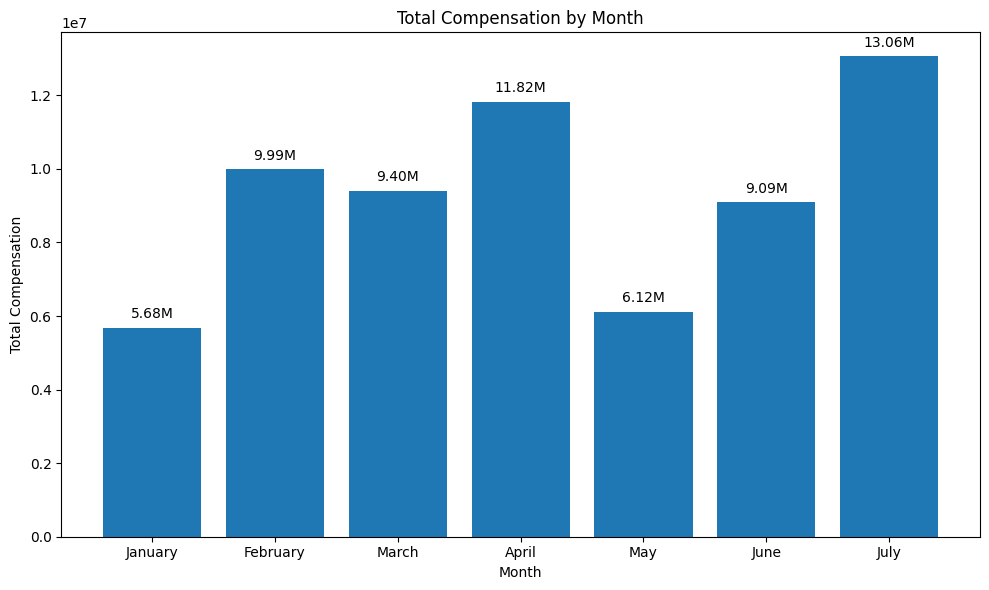

In [180]:
import matplotlib.pyplot as plt

# Group the data by month and calculate the total compensation for each month
monthly_compensation = df.groupby('Month')['Compensation'].sum()

# Ensure months are in the correct order (January to June)
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July']
monthly_compensation = monthly_compensation.reindex(month_order)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar chart, using the month_order as x-axis positions
plt.bar(month_order, monthly_compensation.loc[month_order]) # Plot with month_order as x-axis

# Set title and labels
ax.set_title('Total Compensation by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Total Compensation')

# Add labels above each bar/point with 'M' to indicate millions
for x, y in zip(month_order, monthly_compensation.values):  # Iterate over month_order for x-positions
    ax.annotate(f'{y/1_000_000:.2f}M', (x, y), textcoords="offset points", xytext=(0,7), ha='center')

# Show the plot (no legend needed)
plt.tight_layout()
plt.show()

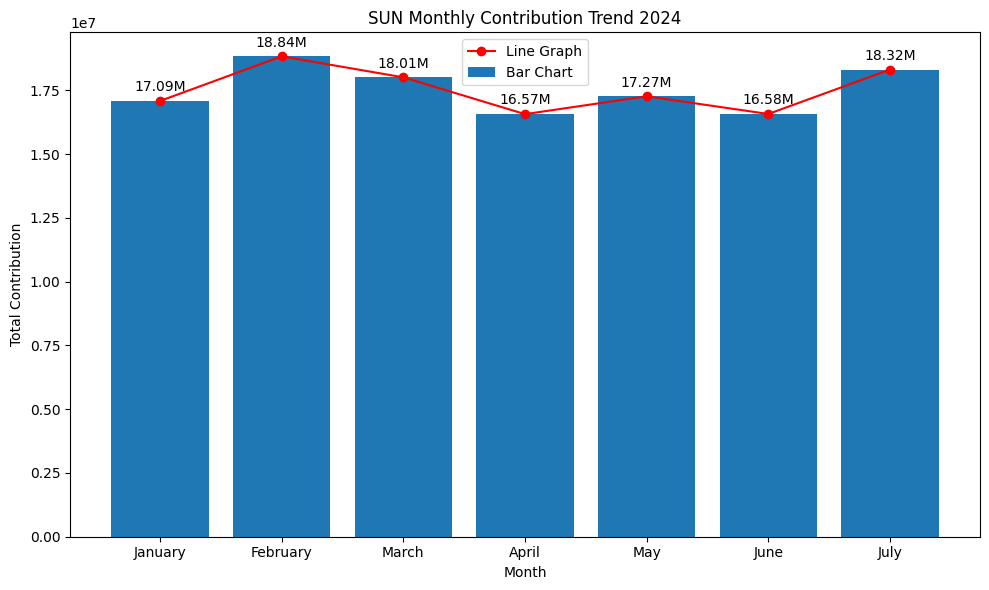

In [181]:
# Group the data by month and calculate the total contributions for each month
monthly_Contribution = df.groupby('Month')['Contribution'].sum()

# Ensure months are in the correct order (January to May)
month_order = ['January', 'February', 'March', 'April', 'May', 'June','July']
monthly_Contribution = monthly_Contribution.reindex(month_order)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bar chart
ax.bar(monthly_Contribution.index, monthly_Contribution.values, label='Bar Chart')

# Plot the line graph
ax.plot(monthly_Contribution.index, monthly_Contribution.values, marker='o', color='red', label='Line Graph')

# Set the title and labels
ax.set_title('SUN Monthly Contribution Trend 2024')
ax.set_xlabel('Month')
ax.set_ylabel('Total Contribution')

# Add labels above each bar/point with 'M' to indicate millions
for x, y in zip(monthly_Contribution.index, monthly_Contribution.values):
    ax.annotate(f'{y/1_000_000:.2f}M', (x, y), textcoords="offset points", xytext=(0,7), ha='center')

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

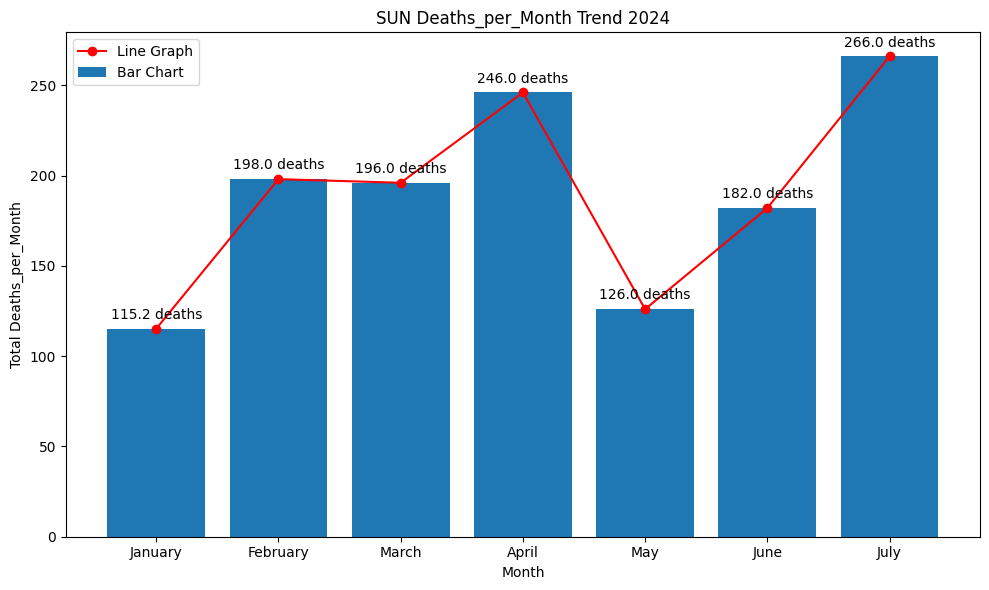

In [182]:
# Group the data by month and calculate the total deaths for each month
monthly_Deaths_per_Month = df.groupby('Month')['Deaths_per_Month'].sum()

# Ensure months are in the correct order (January to May)
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July']
monthly_Deaths_per_Month = monthly_Deaths_per_Month.reindex(month_order)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bar chart
ax.bar(monthly_Deaths_per_Month.index, monthly_Deaths_per_Month.values, label='Bar Chart')

# Plot the line graph
ax.plot(monthly_Deaths_per_Month.index, monthly_Deaths_per_Month.values, marker='o', color='red', label='Line Graph')

# Set the title and labels
ax.set_title('SUN Deaths_per_Month Trend 2024')
ax.set_xlabel('Month')
ax.set_ylabel('Total Deaths_per_Month')

# Add labels above each bar/point with 'M' to indicate millions
for x, y in zip(monthly_Deaths_per_Month.index, monthly_Deaths_per_Month.values):
    ax.annotate(f'{y/1} deaths', (x, y), textcoords="offset points", xytext=(0,7), ha='center')

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [183]:
monthly_Deaths_per_Month.T

Month
January     115.2
February    198.0
March       196.0
April       246.0
May         126.0
June        182.0
July        266.0
Name: Deaths_per_Month, dtype: float64

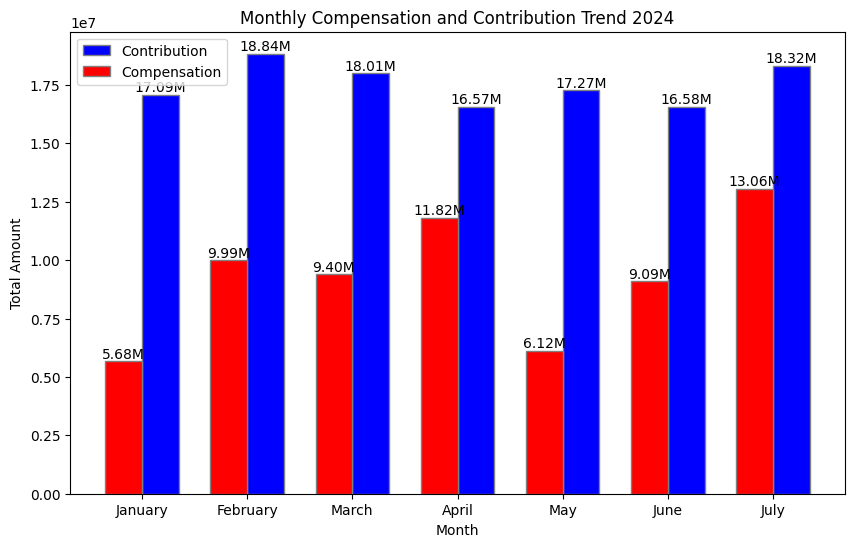

In [184]:
import matplotlib.pyplot as plt
import numpy as np

# Grouping the data by month and calculate the total compensation and contribution for each month
monthly_compensation = df.groupby('Month')['Compensation'].sum()
monthly_contribution = df.groupby('Month')['Contribution'].sum()

# Ensure months are in the correct order (January to May)
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July']
monthly_compensation = monthly_compensation.reindex(month_order)
monthly_contribution = monthly_contribution.reindex(month_order)

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(monthly_compensation))
r2 = [x + bar_width for x in r1]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(r2, monthly_contribution.values, color='blue', width=bar_width, edgecolor='grey', label='Contribution')
bars2 = ax.bar(r1, monthly_compensation.values, color='red', width=bar_width, edgecolor='grey', label='Compensation')


# Add labels, title, and legend
ax.set_xlabel('Month')
ax.set_ylabel('Total Amount')
ax.set_title('Monthly Compensation and Contribution Trend 2024')
ax.set_xticks([r + bar_width/2 for r in range(len(monthly_compensation))])
ax.set_xticklabels(monthly_compensation.index)
ax.legend()

# Add labels on top of each bar
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 5, f'{yval/1_000_000:.2f}M', ha='center', va='bottom')

# Display the plot
plt.show()

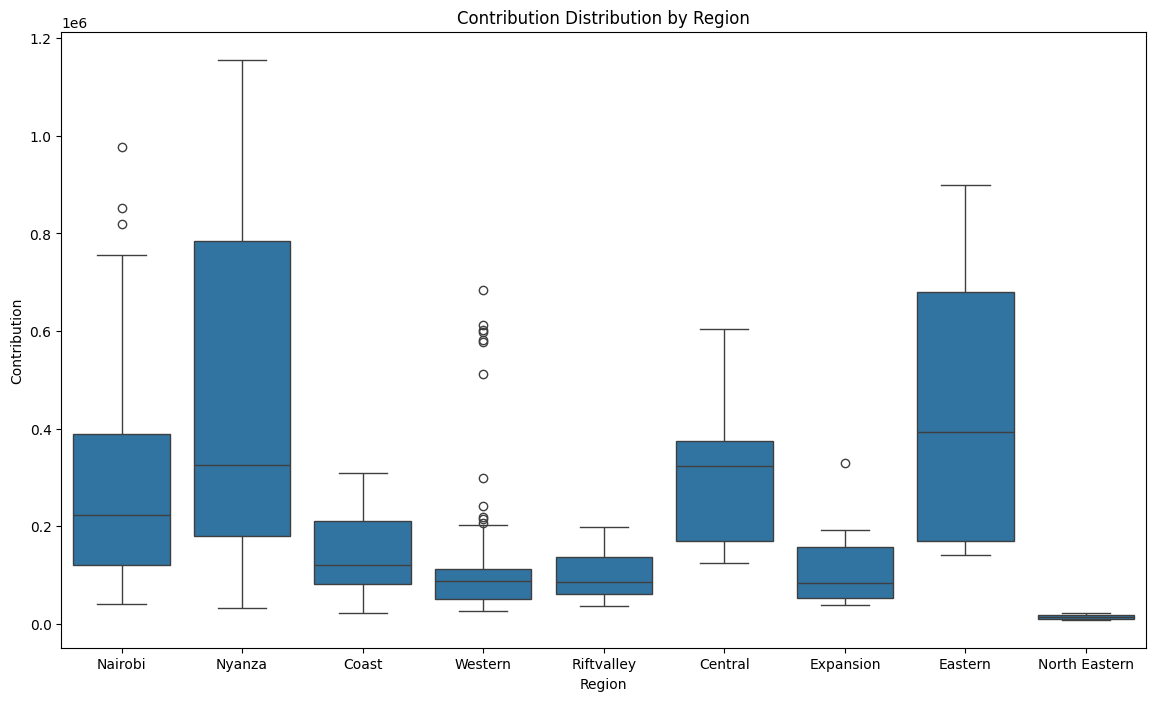

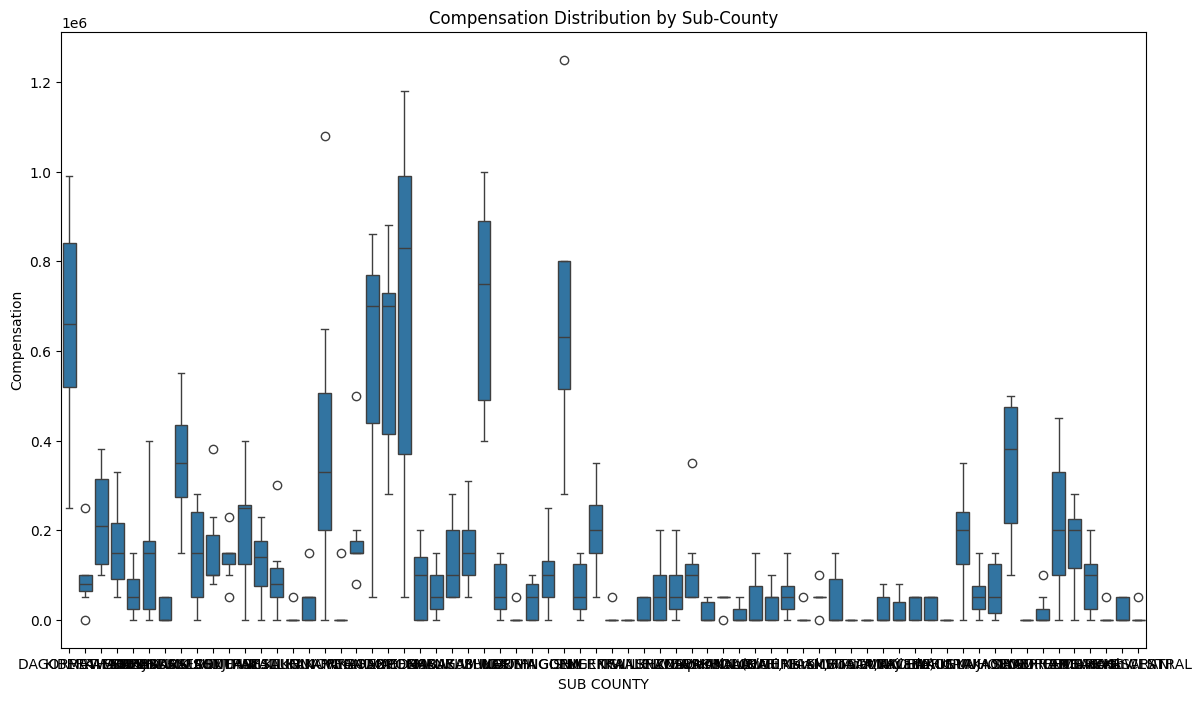

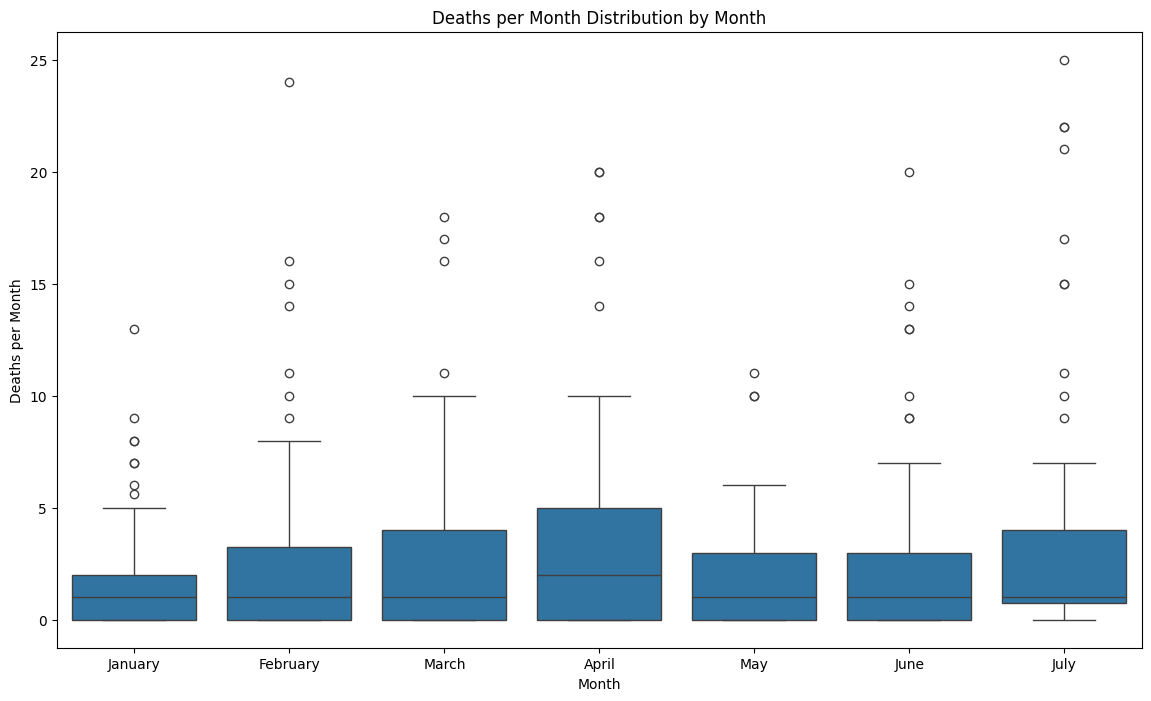

In [185]:
# Distribution
# Contribution Distribution by Region
import seaborn as sns
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='REGION', y='Contribution')
plt.title('Contribution Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Contribution')
plt.show()

# Compensation Distribution by Sub-County
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='SUB COUNTY', y='Compensation')
plt.title('Compensation Distribution by Sub-County')
plt.xlabel('SUB COUNTY')
plt.ylabel('Compensation')
plt.show()

# Deaths per Month Distribution by Month
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='Month', y='Deaths_per_Month')
plt.title('Deaths per Month Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Deaths per Month')
plt.show()



# 1. Are contributions consistently high across all regions, or are there regions with significantly lower or higher contributions?
# 2. Is the compensation distribution similar across different sub-counties, or do some areas receive more compensation?
# 3. How are deaths distributed across different months? Are there months with unusually high or low deaths?

In [186]:
metrics = df.groupby('REGION')[['Contribution', 'Compensation', 'Deaths_per_Month']].agg(['mean', 'max', 'min']).reset_index()
metrics


0         REGION   Contribution                        Compensation  \
                           mean        max       min           mean   
0        Central  292667.190476   603610.0  125221.0   50000.000000   
1          Coast  143463.311688   308730.0   21150.0   62077.922078   
2        Eastern  436727.500000   899063.0  140900.0   25714.285714   
3      Expansion  124776.285714   330301.0   39135.0    7142.857143   
4        Nairobi  285714.866071   976470.0   40100.0  173571.428571   
5  North Eastern   14193.714286    21400.0    8300.0       0.000000   
6         Nyanza  437549.067227  1156057.0   33100.0  248151.260504   
7     Riftvalley   99958.178571   199095.0   37100.0   37857.142857   
8        Western  126727.670330   684400.0   27105.0   97692.307692   

0                 Deaths_per_Month             
         max  min             mean   max  min  
0   150000.0  0.0         1.000000   3.0  0.0  
1   400000.0  0.0         1.280519   8.0  0.0  
2    80000.0  0.0         0.571429   2.0  0.0  
3    50000.0  0.0         0.142857   1.0  0.0  
4  1080000.0  0.0         3.562500  21.0  0.0  
5        0.0  0.0         0.000000   0.0  0.0  
6  1250000.0  0.0         5.080672  25.0  0.0  
7   150000.0  0.0         0.785714   3.0  0.0  
8  1000000.0  0.0         1.923077  20.0  0.0

In [187]:
corr = df[['Contribution', 'Compensation', 'Deaths_per_Month']].corr()
corr


,Contribution,Compensation,Deaths_per_Month
0,,,
Contribution,1.000000,0.670084,0.673389
Compensation,0.670084,1.000000,0.989947
Deaths_per_Month,0.673389,0.989947,1.000000


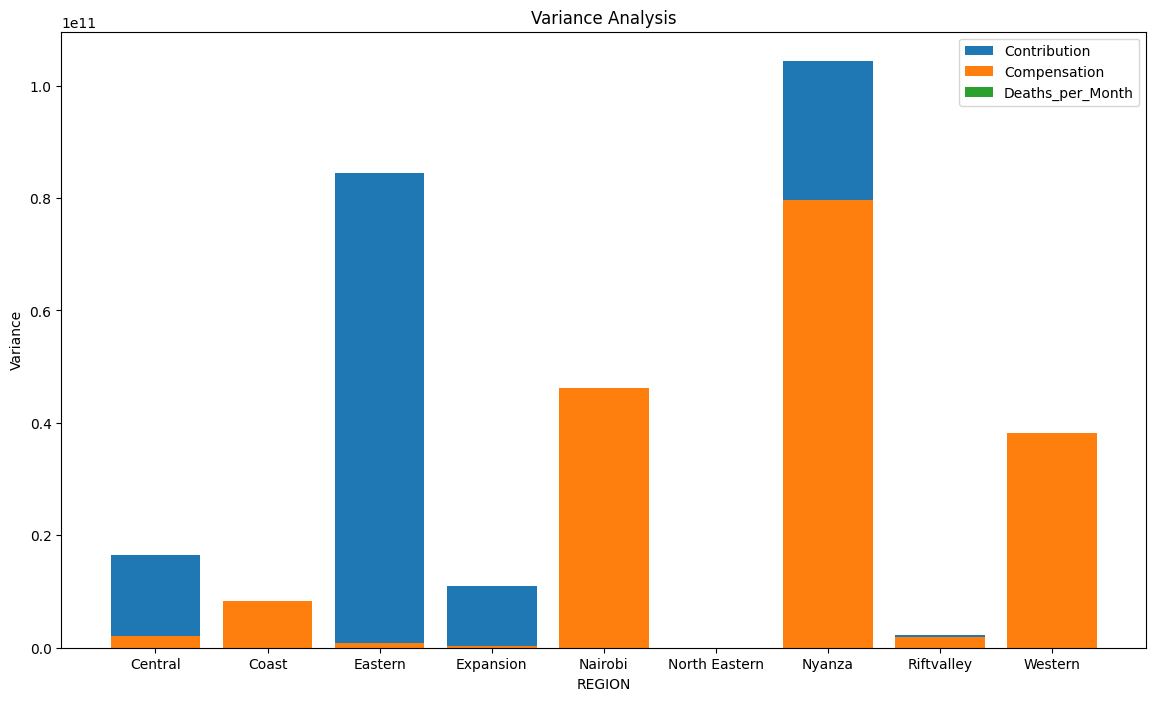

In [188]:
variance = df.groupby('REGION')[['Contribution', 'Compensation', 'Deaths_per_Month']].var().reset_index()
plt.figure(figsize=(14, 8))
plt.bar(variance['REGION'], variance['Contribution'], label='Contribution')
plt.bar(variance['REGION'], variance['Compensation'], label='Compensation')
plt.bar(variance['REGION'], variance['Deaths_per_Month'], label='Deaths_per_Month')
plt.xlabel('REGION')
plt.ylabel('Variance')
plt.title('Variance Analysis')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0         Contribution   Compensation  Deaths_per_Month
Cluster                                                
0        136181.359050   43887.240356          0.883086
1        791323.029412  774705.882353         15.735294
2        475057.247619  228857.142857          4.729524


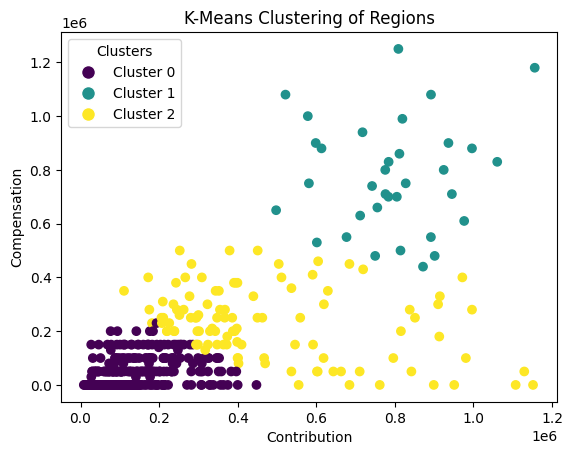

In [189]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming 'df' is your DataFrame with features like 'Contribution', 'Compensation', 'Deaths_per_Month', etc.

# Select relevant features for clustering
features = ['Contribution', 'Compensation', 'Deaths_per_Month']
X = df[features]

# Standardize the features (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters (you can use methods like the Elbow method)
# For this example, let's assume 3 clusters
n_clusters = 3

# Create and fit the K-Means model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_scaled)

# Get the cluster labels for each region
df['Cluster'] = kmeans.labels_

# Analyze the clusters
print(df.groupby('Cluster')[features].mean())  # Analyze mean values for each cluster

# Visualize the clusters (example for 2D visualization - you might need dimensionality reduction for more features)
scatter = plt.scatter(df['Contribution'], df['Compensation'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Contribution')
plt.ylabel('Compensation')
plt.title('K-Means Clustering of Regions')

# Create a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
                           markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10) for i in range(n_clusters)]
plt.legend(handles=legend_elements, title='Clusters')

plt.show()

## interpret the K-Means clustering
insights and considerations:

Understanding the Scatter Plot:

Axes: The x-axis represents the 'Contribution' variable, and the y-axis represents the 'Compensation' variable. Each point on the graph represents a region.
Colors: The different colors represent the different clusters that K-Means has identified.
Clusters: Regions that are closer together on the graph and share the same color are considered more similar to each other in terms of their 'Contribution' and 'Compensation' values.
Interpreting the Clusters:

Cluster Centers: tried to identify the approximate center of each cluster. This gave me an idea of the typical 'Contribution' and 'Compensation' values for regions within that cluster.
Cluster Characteristics:
High Contribution, High Compensation: A cluster in the top-right quadrant might indicate regions with both high contributions and high compensation.
Low Contribution, Low Compensation: A cluster in the bottom-left quadrant might represent regions with both low contributions and low compensation.
Other Patterns: You might observe clusters with high contribution but low compensation, or vice versa.
Potential Insights and Further Investigation:

Underlying Factors: Once you identify the general characteristics of each cluster, try to understand the potential underlying factors driving those similarities.
Economic Factors: Are the regions in a high-contribution cluster wealthier or more developed?
Population Density: Do regions with higher population density tend to cluster together?
Other Variables: Consider how other variables in your dataset (like 'Deaths_per_Month' or any additional features) might relate to the cluster assignments.
Targeted Strategies: The clustering results can help inform targeted strategies for different regions. For example, regions in a low-contribution cluster might require different outreach or support compared to those in a high-contribution cluster.
Further Analysis:
Statistical Tests: You can perform statistical tests (like ANOVA) to assess whether the differences between clusters are statistically significant.

Cluster
 2    432
-1     30
 0      7
 1      7
Name: count, dtype: int64
0         Contribution   Compensation  Deaths_per_Month
Cluster                                                
-1       836003.733333  642333.333333         12.933333
 0       764232.428571  705714.285714         14.571429
 1       891244.285714  260000.000000          5.371429
 2       199098.756944   90578.703704          1.855556


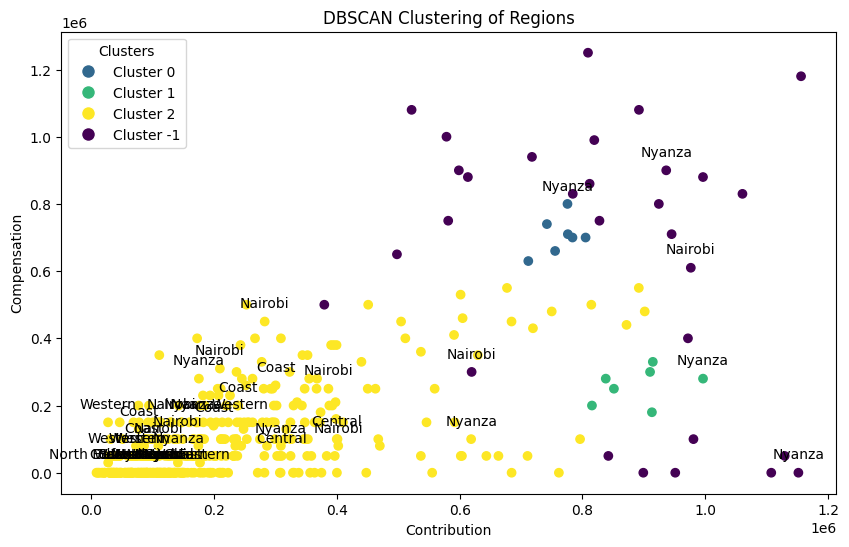

In [190]:
from sklearn.cluster import DBSCAN
# Determine appropriate values for eps (distance threshold) and min_samples (minimum points in a neighborhood)
eps = 0.5
min_samples = 5

# Create and fit the DBSCAN model
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
df['Cluster'] = dbscan.fit_predict(X_scaled)

# Analyze the clusters (including noise points labeled as -1)
print(df['Cluster'].value_counts())
print(df.groupby('Cluster')[features].mean())

# Visualize the clusters with labels (example for 2D visualization)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['Contribution'], df['Compensation'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Contribution')
plt.ylabel('Compensation')
plt.title('DBSCAN Clustering of Regions')

# Add labels for a subset of points (for clarity)
# Use df.index to ensure you are iterating over the correct index values
for i in df.index[::10]:  # Label every 10th point (adjust as needed)
    plt.annotate(df['REGION'][i], (df['Contribution'][i], df['Compensation'][i]),
                 textcoords="offset points", xytext=(0,10), ha='center')

# Create a legend for the clusters
# Get unique cluster labels, including noise if present
unique_labels = set(df['Cluster'])
# Create legend elements for each cluster
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
                           markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10)
                   for i in unique_labels]
plt.legend(handles=legend_elements, title='Clusters')

plt.show()